"""
MNIST GAN Implementation with TensorFlow
--------------------------------------
This implementation provides a flexible GAN architecture for generating MNIST digits.
The code includes detailed comments and instructions for scaling model complexity.

Scaling Instructions:
1. Model Depth: Adjust by adding/removing Conv2DTranspose layers in generator
   and Conv2D layers in discriminator
2. Model Width: Modify the number of filters in each layer
3. Latent Space: Adjust LATENT_DIM for different noise vector dimensions
4. Resolution: Careful adjustment of strides and layer dimensions needed

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_data():
    """
    Load and preprocess MNIST dataset.

    Returns:
        numpy.ndarray: Preprocessed training images in range [-1, 1]

    Note:
        - Images are reshaped to (28, 28, 1) for CNN compatibility
        - Normalization to [-1, 1] matches generator's tanh output
    """
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

    # Add channel dimension and convert to float32
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

    # Normalize to [-1, 1]
    train_images = (train_images - 127.5) / 127.5

    return train_images

In [ ]:
def build_generator(latent_dim, complexity_factor=1):
    """
    Build the Generator model with adjustable complexity.

    Args:
        latent_dim (int): Dimension of input noise vector
        complexity_factor (int): Multiplier for model capacity (default: 1)

    Returns:
        tf.keras.Model: Compiled generator model

    Scaling Notes:
        - Increase complexity_factor to widen the network
        - Base filter counts are multiplied by complexity_factor
        - Keep powers of 2 for better performance
    """
    # Base filter counts - adjust these for different model capacities
    base_filters = 64 * complexity_factor

    model = models.Sequential([
        # Input layer for noise vector
        layers.Input(shape=(latent_dim,)),

        # Initial dense layer to create feature map basis
        # 7*7*base_filters*4 maintains proportional scaling
        layers.Dense(7 * 7 * base_filters * 4, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),

        # Reshape to start convolutional operations
        layers.Reshape((7, 7, base_filters * 4)),

        # First upsampling block: 7x7 -> 7x7
        layers.Conv2DTranspose(base_filters * 2, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),

        # Second upsampling block: 7x7 -> 14x14
        layers.Conv2DTranspose(base_filters, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),

        # Final upsampling block: 14x14 -> 28x28
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])

    return model

In [ ]:
def build_discriminator(complexity_factor=1):
    """
    Build the Discriminator model with adjustable complexity.

    Args:
        complexity_factor (int): Multiplier for model capacity (default: 1)

    Returns:
        tf.keras.Model: Compiled discriminator model

    Scaling Notes:
        - Increase complexity_factor to widen the network
        - Dropout rates can be adjusted based on model size
        - Consider adding layers for very high complexity_factor
    """
    # Base filter counts
    base_filters = 64 * complexity_factor

    model = models.Sequential([
        # Input layer
        layers.Input(shape=(28, 28, 1)),

        # First conv block: 28x28 -> 14x14
        layers.Conv2D(base_filters, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.3),

        # Second conv block: 14x14 -> 7x7
        layers.Conv2D(base_filters * 2, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

def wasserstein_loss(y_true, y_pred):
    """
    Wasserstein loss function - alternative to cross entropy.
    More stable for GAN training but requires architecture adjustments.
    """
    return tf.reduce_mean(y_true * y_pred)

In [ ]:
class MNIST_GAN:
    """
    MNIST GAN wrapper class for easier training and generation.
    """
    def __init__(self, latent_dim=100, complexity_factor=1, use_wasserstein=False):
        self.latent_dim = latent_dim
        self.complexity_factor = complexity_factor
        self.generator = build_generator(latent_dim, complexity_factor)
        self.discriminator = build_discriminator(complexity_factor)
        self.use_wasserstein = use_wasserstein

        # Initialize optimizers with beta_1=0.5 for better training stability
        self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

        # Choose loss function
        if use_wasserstein:
            self.loss_fn = wasserstein_loss
        else:
            self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def discriminator_loss(self, real_output, fake_output):
        """Calculate discriminator loss with label smoothing."""
        if self.use_wasserstein:
            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(-tf.ones_like(fake_output), fake_output)
        else:
            # Use label smoothing (0.9) for real samples
            real_loss = self.loss_fn(tf.ones_like(real_output) * 0.9, real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        """Calculate generator loss."""
        if self.use_wasserstein:
            return self.loss_fn(tf.ones_like(fake_output), fake_output)
        else:
            return self.loss_fn(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images, batch_size):
        """Single training step for both networks."""
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        # Calculate and apply gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables))

        return gen_loss, disc_loss

    def train(self, dataset, epochs, batch_size=128):
        """Complete training loop with progress visualization."""
        dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(60000).batch(batch_size)

        for epoch in range(epochs):
            for image_batch in dataset:
                gen_loss, disc_loss = self.train_step(image_batch, batch_size)

            # Show progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
                self.generate_and_plot_images(16)

    def generate_and_plot_images(self, num_examples=16):
        """Generate and display sample images."""
        noise = tf.random.normal([num_examples, self.latent_dim])
        generated_images = self.generator(noise, training=False)

        fig = plt.figure(figsize=(4, 4))
        for i in range(num_examples):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 10, Gen Loss: 0.8532, Disc Loss: 1.2608


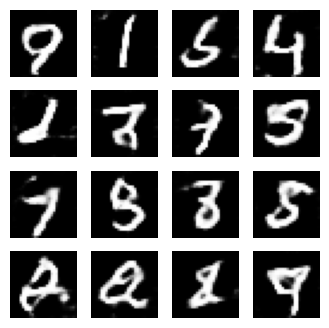

Epoch 20, Gen Loss: 0.8077, Disc Loss: 1.3413


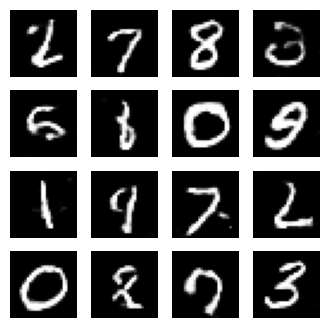

Epoch 30, Gen Loss: 1.0955, Disc Loss: 1.3059


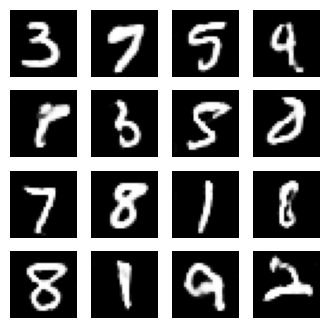

Epoch 40, Gen Loss: 0.8125, Disc Loss: 1.3106


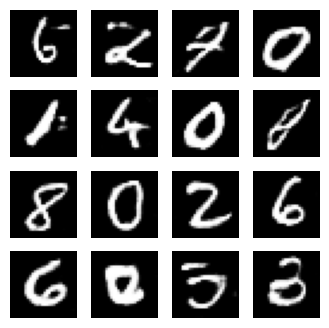

Epoch 50, Gen Loss: 1.0520, Disc Loss: 1.3456


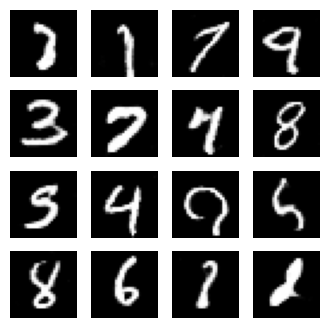

Epoch 60, Gen Loss: 1.0184, Disc Loss: 1.2312


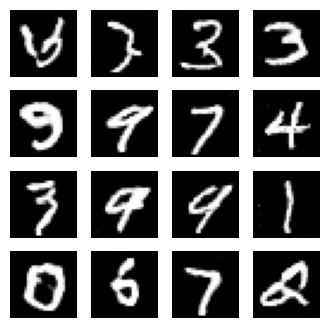

Epoch 70, Gen Loss: 0.8423, Disc Loss: 1.2885


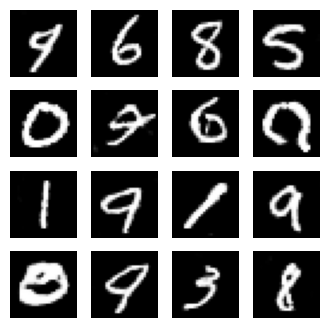

Epoch 80, Gen Loss: 0.9504, Disc Loss: 1.2996


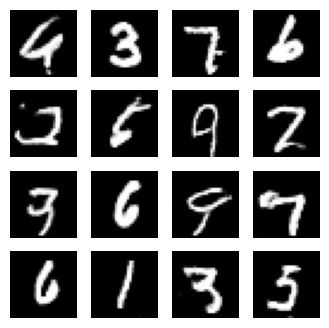

Epoch 90, Gen Loss: 0.9402, Disc Loss: 1.2661


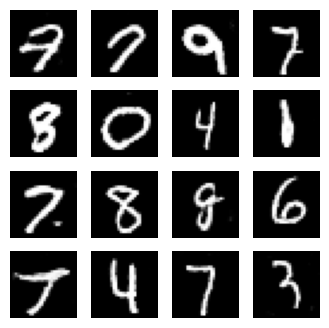

Epoch 100, Gen Loss: 0.9619, Disc Loss: 1.3339


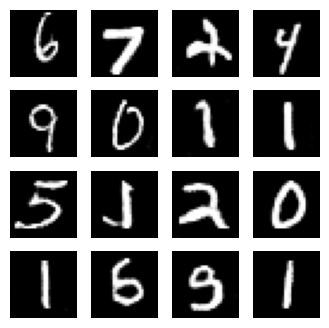

Epoch 110, Gen Loss: 1.0827, Disc Loss: 1.2880


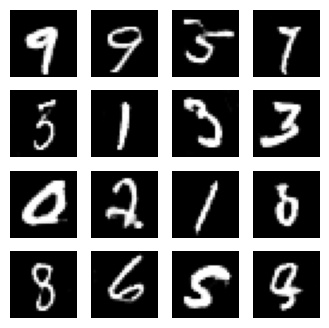

Epoch 120, Gen Loss: 0.8555, Disc Loss: 1.2519


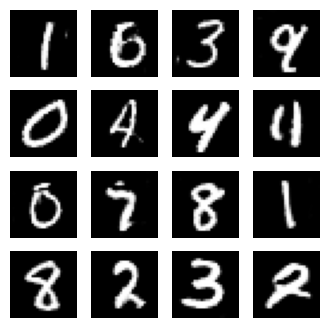

Epoch 130, Gen Loss: 0.8298, Disc Loss: 1.3032


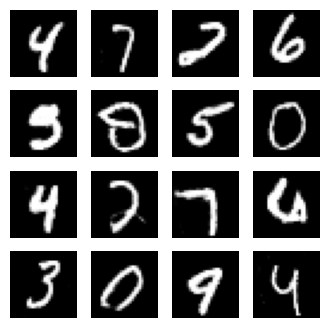

In [ ]:
def main():
    """
    Main execution function with hyperparameter settings.
    Complexity Scaling Guide:
    1. Start with base parameters below
    2. For higher quality:
       - Increase COMPLEXITY_FACTOR (2, 4, 8)
       - Increase LATENT_DIM (200, 512)
       - Decrease BATCH_SIZE (64, 32)
       - Increase EPOCHS (200, 500)
    3. For faster training:
       - Decrease COMPLEXITY_FACTOR (0.5)
       - Decrease LATENT_DIM (50)
       - Increase BATCH_SIZE (256)
       - Decrease EPOCHS (50)
    """
    # Base hyperparameters
    EPOCHS = 1000
    BATCH_SIZE = 256
    LATENT_DIM = 100
    COMPLEXITY_FACTOR = 8
    USE_WASSERSTEIN = False  # Set to True for potentially more stable training

    # Load and preprocess data
    train_images = load_and_preprocess_data()

    # Initialize and train GAN
    gan = MNIST_GAN(LATENT_DIM, COMPLEXITY_FACTOR, USE_WASSERSTEIN)
    gan.train(train_images, EPOCHS, BATCH_SIZE)

    # Save models
    gan.generator.save('mnist_generator.keras')
    gan.discriminator.save('mnist_discriminator.keras')

if __name__ == "__main__":
    main()